### Supervisor Pattern
* Idea is you have an inventory supervisor and an inventory manager. The supervisor routes tasks and determines if the task is completed and the inventory manager executes tasks using the tools available. In this case we created a sqlite database and provided the inventory manager a tool to query the database
* Following the design here: https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/agent_supervisor.ipynb

In [ ]:
import os 
os.environ['OPENAI_API_KEY']

### Setup

In [3]:
from typing import Annotated 
from langchain_core.tools import tool
import sqlite3

In [4]:
# Create a database and populate it with sample data for this exercise
def connection():
    return sqlite3.connect("inventory_example.db")

def setup_database(connection):
    cursor = connection.cursor()
    # Create table
    cursor.execute("""DROP TABLE IF EXISTS suppliers;""")
    cursor.execute("""DROP TABLE IF EXISTS inventory;""")

    # Suppliers table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS suppliers (
            name TEXT,
            item TEXT,
            price_per_unit INTEGER,
            delivery_time INTEGER
        );
    """)
    # Insert sample data
    cursor.executemany("""
        INSERT INTO suppliers (name, item, price_per_unit, delivery_time) VALUES (?, ?, ?, ?);
    """, [
        ("Supplier A", "Laptop", 1200, 5),
        ("Supplier B", "Laptop", 1150, 7)
    ])

    # Inventory table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS inventory (
            item TEXT,
            on_hand_qty INTEGER,
            minimum_required_qty INTEGER
        );
    """)
    # Insert sample data
    cursor.executemany("""
        INSERT INTO inventory (item, on_hand_qty, minimum_required_qty) VALUES (?, ?, ?);
    """, [
        ("Laptop", 3, 6),
        ("Couch", 6, 5)
    ])

    connection.commit()

# setup
conn = connection()
setup_database(connection=conn)
conn.close()



### Create Tools

In [6]:
def run_sql_queries(code: Annotated[str, "The SQL code to execute to return data."]):
    """
    Used to run sql queries against company database.
    """
    conn = sqlite3.connect("inventory_example.db")
    cursor = conn.cursor()
    try:
        print(f"Code being executed on SQL tool: {code}")
        cursor.execute(code)
        results = cursor.fetchall()
        conn.close()
        if results:
            return str(results)
        else:
            return "No results found."
    except Exception as e:
        conn.close()
        return f"Error: {str(e)}"

### Create Agent Supervisor

In [7]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END 
from langgraph.types import Command

In [8]:
team_members = ["inventory_manager"]
options = team_members + ["FINISH"]

system_prompt = (
    """You are an inventory supervisor tasked with managing a team to fulfill inventory related requests. 
    Your team consists of the following workers: {team_members}. Given the user request, respond with the worker to act next. 
    Each worker will perform a task and respond with their results and status. When you determine the user request is
    completed respond with FINISH."""
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

llm = ChatOpenAI(model_name="gpt-4-turbo")

class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*team_members, "__end__"]]:
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    print(f"Supervisor Response: {response}")
    goto = response["next"]
    if goto == "FINISH":
        goto = END 
    return Command(goto=goto, update={"next": goto})


### Construct Graph

In [9]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent, InjectedState
from langchain_core.tools import Tool


# Inventory Manager
inventory_manager_prompt = """You are an inventory manager. 
Use your knowledge of inventory management and the available tools to answer the user's request.

Tools:
- run_sql_queries: A data analyst capable of retrieving inventory related data.
"""

inventory_manager_agent = create_react_agent(llm, tools=[run_sql_queries])


def inventory_manager_node(state: State) -> Command[Literal["supervisor"]]:
    print(f"Inventory Manager state: {state}")
    result = inventory_manager_agent.invoke(state)
    print(f"Inventory Manager response: {result}")
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="inventory_manager")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("inventory_manager", inventory_manager_node)
graph = builder.compile()


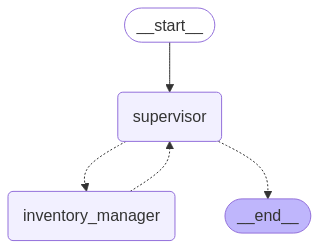

In [10]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# for s in graph.stream(
#     {"messages": [("user", "How many products are in our inventory?")]}, subgraphs=True
# ):
#     print(s)
#     print("----")


for s in graph.stream(
    {"messages": [("user", "How many products are in our inventory?")]}, stream_mode="values"
):
    print(s["messages"][-1].pretty_print())
    print("----")

================================ Human Message =================================

How many products are in our inventory?
None
----


/Users/conbirk/Documents/Projects/LearningAgentPatterns/myvenv/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-4-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Supervisor Response: {'next': 'inventory_manager'}
================================ Human Message =================================

How many products are in our inventory?
None
----
Inventory Manager state: {'messages': [HumanMessage(content='How many products are in our inventory?', additional_kwargs={}, response_metadata={}, id='4b282f0d-85c7-4c97-9ac8-81fcbbf86430')], 'next': 'inventory_manager'}
Code being executed on SQL tool: SELECT COUNT(*) AS total_products FROM products
Inventory Manager response: {'messages': [HumanMessage(content='How many products are in our inventory?', additional_kwargs={}, response_metadata={}, id='4b282f0d-85c7-4c97-9ac8-81fcbbf86430'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e1Z9qgm7VaPRpGC0E68pRyYq', 'function': {'arguments': '{"code":"SELECT COUNT(*) AS total_products FROM products"}', 'name': 'run_sql_queries'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_t

/Users/conbirk/Documents/Projects/LearningAgentPatterns/myvenv/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-4-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Supervisor Response: {'next': 'FINISH'}
================================ Human Message =================================
Name: inventory_manager

It seems there was an issue accessing the data regarding products in the inventory because the table `products` does not exist in the database. There might be a mistake in accessing the right database or table name. Can you please verify the database or the table name for the inventory information?
None
----
